In [6]:
from skimage import color
from skimage import morphology
from skimage.segmentation import felzenszwalb
from PIL import Image
from scipy.ndimage import imread
from scipy.misc import imresize

from skimage import filters

from scipy.misc import imresize


import math
import seg_helper as segh
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage.measure as sk_measure

import pymeanshift as pms
from growcut import growcut_cy
from skimage.segmentation import random_walker

2.jpg


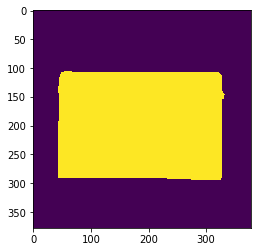

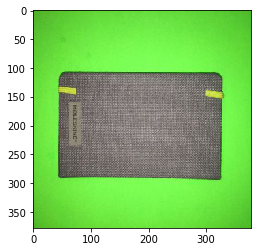

378 378 378 378 (378, 378)
[False  True]


In [7]:
# read image
filename_num = '2'#'4.png'# ##
file_suffix = '.jpg'
print(filename_num+file_suffix)
input_img = imread(''.join(['./Dataset/simple/',filename_num + file_suffix]))
t_mask = imread(''.join(['./Dataset/simple/' + filename_num + '_ground' +file_suffix ]))
t_mask = t_mask>128
plt.imshow(t_mask), plt.show()
input_m, input_n,_ = np.shape(input_img)
ori_img,in_u,in_d,in_l,in_r = segh.get_rid_of_black_frame(input_img)
ori_m, ori_n,_ = np.shape(ori_img)
plt.imshow(ori_img), plt.show()

# downsampling 400 400
target_total_pixel = 600*600
rgb_img = ori_img
m,n,_ = np.shape(rgb_img)
n_rgb_img = segh.normalize_rgb(rgb_img)
hsv_img = color.rgb2hsv(rgb_img)

print(m, n, input_m, input_n, t_mask.shape)
print(np.unique(t_mask))

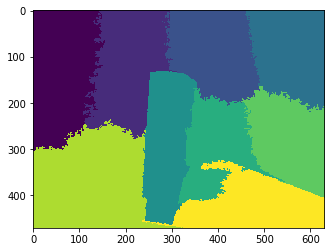

(<matplotlib.image.AxesImage at 0x15c256b3ef0>, None)

In [62]:
slic_out = slic(rgb_img, n_segments = 10, multichannel=True)
plt.imshow(slic_out), plt.show()

# Felzenswalb

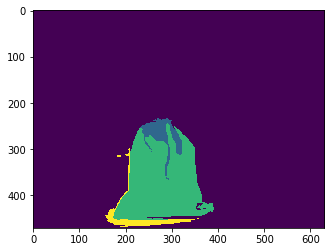

[0 1 2 3] 0


In [25]:
largeness = 1000
seg_image = felzenszwalb(rgb_img, scale=largeness, sigma=0.5, min_size=largeness)
plt.imshow(seg_image), plt.show()

fel_seg_ids = (np.unique(seg_image))
id_segs_dict = {}

for seg_id in fel_seg_ids:
    id_segs_dict[seg_id] = (seg_id==seg_image)*1        

fore_mask, back_id = segh.identify_background(seg_image, id_segs_dict,0.1)
print(np.unique(seg_image), back_id)
fore_mask=fore_mask!=back_id

cl = 5
closed_fore_mask = segh.close_image_with_back(fore_mask, cl)

fore_mask = segh.put_back_boundary(fore_mask, closed_fore_mask, cl) 

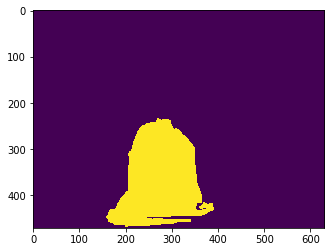

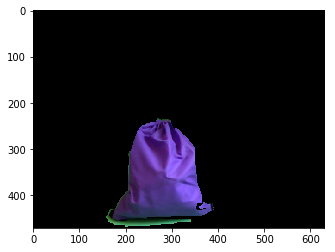

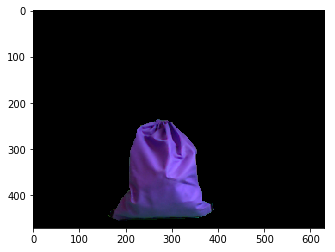

old_metric_result 89.53241232731138


In [26]:
# choose one object
fel_labeled_image, fel_object_mask = segh.get_object_mask_from_connected_regions(fore_mask)
plt.imshow(fel_object_mask), plt.show()
plt.imshow(segh.mask_rgb(fel_object_mask, rgb_img)), plt.show()
plt.imshow(segh.mask_rgb(t_mask, rgb_img)), plt.show()

segh.old_metrics(fel_object_mask, t_mask)

# GrabCut

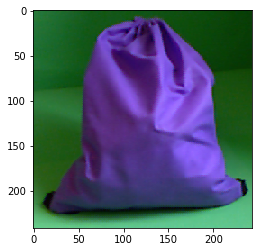

In [27]:
# improve by mask
extend = 5
crop_local_mask, crop_local_image, crop_u,crop_d, crop_l, crop_r = segh.crop_image(fel_object_mask, rgb_img, extend)
lm, ln = np.shape(crop_local_mask)

crop_local_lab = color.rgb2lab(crop_local_image)
crop_local_hsv = color.rgb2hsv(crop_local_image)
plt.imshow(crop_local_image); plt.show()

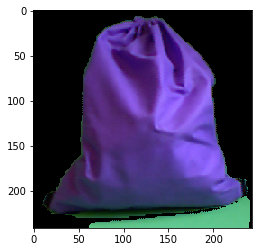

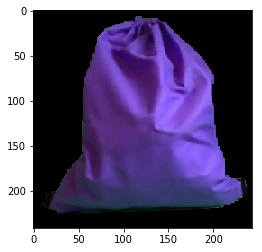

old_metric_result 88.57263632520784


In [28]:
mask = np.zeros((m, n), np.uint8)

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
x = crop_u
y = crop_l
w = crop_r-crop_l
h = crop_d-crop_u
rect = (y,x,w,h)

cv2.grabCut(rgb_img,mask,rect,bgdModel,fgdModel,30,cv2.GC_INIT_WITH_RECT)
rect_mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')

se = np.array([[0,1,0],[1,1,1],[0,1,0]])
closed_fore_mask = morphology.binary_closing(rect_mask==0, se)==0
rect_mask = segh.put_back_boundary(rect_mask, closed_fore_mask, 3) 

grab_cut_img = rgb_img * rect_mask[:,:,np.newaxis]
t_img = segh.mask_rgb(t_mask, rgb_img)

plt.imshow(grab_cut_img[crop_u:crop_d, crop_l:crop_r]),plt.show()
plt.imshow(t_img[crop_u:crop_d, crop_l:crop_r]),plt.show()




segh.old_metrics(rect_mask, t_mask)

# meanshift

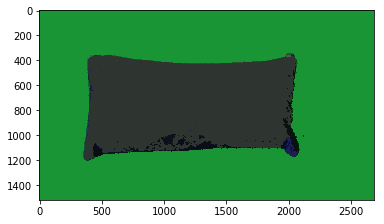

(<matplotlib.image.AxesImage at 0x295ace26c18>, None)

In [11]:
(segmented_image, labels_image, number_regions) = pms.segment(rgb_img, spatial_radius=5,#20, 
                                                              range_radius=10, min_density=50)
plt.imshow(segmented_image), plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36] 0


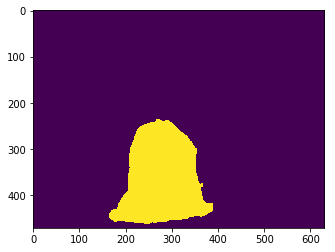

old_metric_result 95.75296679034682


In [30]:
meanShift_id_segs_dict = {}
for i in range(number_regions):
    meanShift_id_segs_dict[i] = (i==labels_image)*1        

fore_mask, back_id = segh.identify_background(labels_image, meanShift_id_segs_dict, 0.1)
print(np.unique(labels_image), back_id)
fore_mask=fore_mask!=back_id

cl = 5
closed_fore_mask = segh.close_image_with_back(fore_mask, cl)

fore_mask = segh.put_back_boundary(fore_mask, closed_fore_mask, cl) 

labeled_image, object_mask = segh.get_object_mask_from_connected_regions(fore_mask)
plt.imshow(object_mask), plt.show()
segh.old_metrics(object_mask, t_mask)

# growcut - is very error resistant

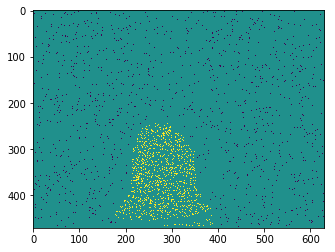

10
20
30
40
50
60
70


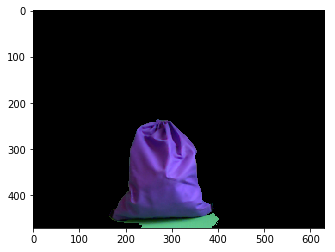

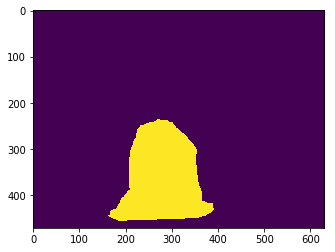

old_metric_result 88.52009830230784


In [31]:
grow_fore_points = morphology.binary_erosion(rect_mask, np.ones((10,10)))
grow_back_points = morphology.binary_erosion(rect_mask==0, np.ones((5,5)))
num = 5000
#sampling point
fore_points = segh.get_sample_point(rgb_img, num, grow_fore_points)
back_points = segh.get_sample_point(rgb_img, num, grow_back_points)
label_img =np.zeros((m,n))
strength = np.zeros((m,n))

for p in fore_points:
    i,j = p[-2], p[-1]
    label_img[i,j] = 1
    
for p in back_points:
    i,j = p[-2], p[-1]
    label_img[i,j] = -1    

strength[np.nonzero(label_img)] = 1.0


plt.imshow(label_img), plt.show()

grow_mask = growcut_cy.growcut((rgb_img), np.dstack((label_img, strength)), window_size=8) >0
plt.imshow(segh.mask_rgb(grow_mask,rgb_img)), plt.show()
plt.imshow(t_mask), plt.show()
segh.old_metrics(grow_mask, t_mask)
#plt.imshow(segh.mask_rgb(grow_back_points, rgb_img)), plt.show()

# growcut unsampled

In [32]:
grow_fore_points = morphology.binary_erosion(rect_mask, np.ones((10,10)))
grow_back_points = morphology.binary_erosion(rect_mask==0, np.ones((10,10)))

strength = np.zeros((m,n), dtype=np.float64)
label_img = grow_fore_points*1.0  - grow_back_points*1.0
strength[np.nonzero(label_img)] = 1.0
#plt.imshow(label_img), plt.show()

grow_mask = growcut_cy.growcut((rgb_img), np.dstack((label_img, strength)), window_size=4) >0
plt.imshow(segh.mask_rgb(grow_mask,rgb_img)), plt.show()
plt.imshow(t_mask), plt.show()
segh.old_metrics(grow_mask, t_mask)

# random walk not sampled work better faster

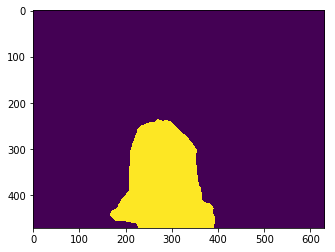

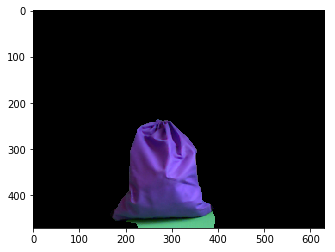

old_metric_result 88.65938430983118


In [35]:
rand_fore_points = morphology.binary_erosion(rect_mask, np.ones((10,10)))
rand_back_points = morphology.binary_erosion(rect_mask==0, np.ones((5,5)))
labels = rand_fore_points*1.0  + 2.0*rand_back_points

#plt.imshow(label_img), plt.show()

random_walker_mask = random_walker(rgb_img, labels, beta=130, multichannel=True)==1
plt.imshow(random_walker_mask), plt.show()           
plt.imshow(segh.mask_rgb(random_walker_mask,rgb_img)), plt.show()           
segh.old_metrics(random_walker_mask, t_mask)          

# random walk sampled

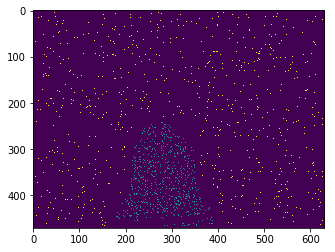

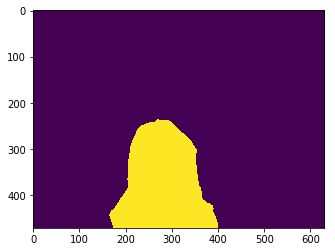

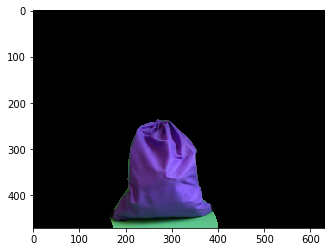

old_metric_result 85.73028796240642


In [36]:
rand_fore_points = morphology.binary_erosion(rect_mask, np.ones((5,5)))
rand_back_points = morphology.binary_erosion(rect_mask==0, np.ones((5,5)))
num = 3000
#sampling point
fore_points = segh.get_sample_point(rgb_img, num, grow_fore_points)
back_points = segh.get_sample_point(rgb_img, num, grow_back_points)
labels =np.zeros((m,n))

for p in fore_points:
    i,j = p[-2], p[-1]
    labels[i,j] = 1    
for p in back_points:
    i,j = p[-2], p[-1]
    labels[i,j] = 2
plt.imshow(labels), plt.show()     

    
random_walker_mask = random_walker(rgb_img, labels, beta=130, multichannel=True)==1
plt.imshow(random_walker_mask), plt.show()           
plt.imshow(segh.mask_rgb(random_walker_mask,rgb_img)), plt.show()           
segh.old_metrics(random_walker_mask, t_mask)          

##### grow_fore_points.shape

<class 'numpy.float64'>


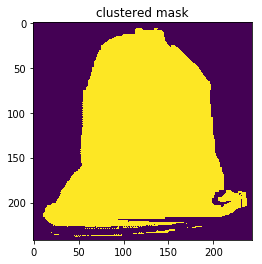

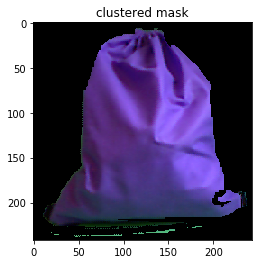

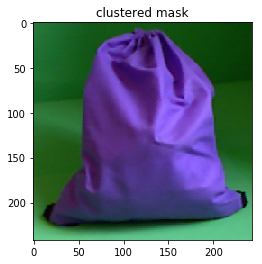

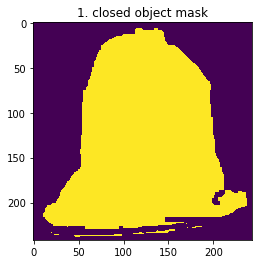

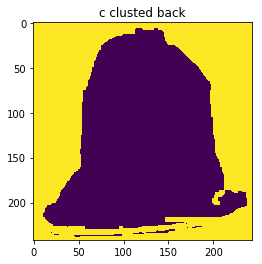

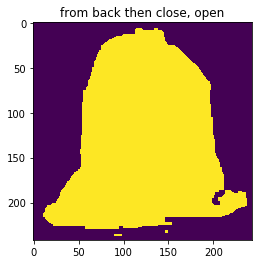

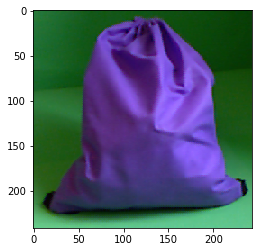

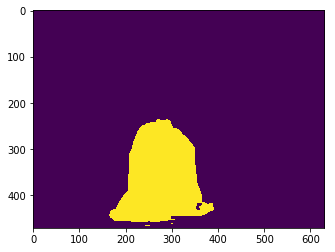

old_metric_result 94.77365999253824


In [39]:
# generate fore back points
l_m,l_n = np.shape(crop_local_mask)

back_num = 200 #math.floor(l_m*l_n/800)
fore_num = back_num*6  # focus more on image
# generate sample points
fore_points = segh.get_sample_point(crop_local_image,fore_num, grow_fore_points[crop_u:crop_d, crop_l:crop_r])

back_points = segh.get_sample_point(crop_local_image,back_num, grow_back_points[crop_u:crop_d, crop_l:crop_r])


centroids = np.concatenate((np.array(fore_points),np.array(back_points)),axis=0)
thresh = fore_num
clustered_mask = segh.cluster_image(crop_local_image, centroids, thresh, False)
# since detecting hole, and with old confident surrounding
clustered_mask = np.logical_and(crop_local_mask, clustered_mask)

segh.plot_mask_image(clustered_mask, crop_local_image)
    
# morphology
first_close_length = 4
#clustered_mask =  morphology.binary_dilation(clustered_mask==0, np.ones((2,2)))==0
c_clustered_mask =  morphology.binary_closing(clustered_mask, np.ones((first_close_length,first_close_length)))
plt.imshow(c_clustered_mask)
plt.title('1. closed object mask')
plt.show()

c_clustered_back = c_clustered_mask==0
#imgplot = plt.imshow(c_clustered_back)
#plt.show()

#c_clustered_back = morphology.binary_closing(c_clustered_back, np.ones((close_length,close_length)))
close_length = first_close_length
segh.pad_boundary(c_clustered_back, close_length,1)
imgplot = plt.imshow(c_clustered_back)
plt.title('c clusted back')
plt.show()

c_clustered_mask = c_clustered_back==0
c_clustered_mask =  morphology.binary_closing(c_clustered_mask, np.ones((close_length,close_length)))
final_c_clustered_mask =  morphology.binary_opening(c_clustered_mask, np.ones((3,3)))
plt.imshow(final_c_clustered_mask)
plt.title('from back then close, open')
plt.show()

out_img = segh.mask_rgb(final_c_clustered_mask, crop_local_image)

imgplot = plt.imshow(crop_local_image)
plt.show()

obj_detail_mask = segh.put_back_cropped_mask(crop_u,crop_d, crop_l,crop_r,final_c_clustered_mask, m,n)                       
imgplot = plt.imshow(obj_detail_mask)
plt.show()
segh.old_metrics(obj_detail_mask, t_mask)  

# slic

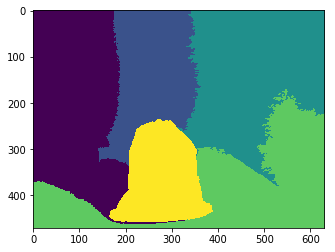

(<matplotlib.image.AxesImage at 0x15c2bddd898>, None)

In [52]:
slic_out = slic(rgb_img, n_segments = 5, multichannel=True)
plt.imshow(slic_out), plt.show()